# Two level oscillation tests

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.linalg as npl
from IPython.core.pylabtools import figsize
%matplotlib inline 

create an artificial data set with several points per time value

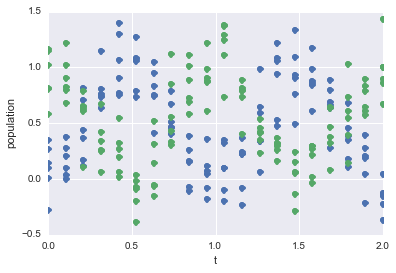

In [3]:
import pymc3 as pm
sigma =0.2;
Omega =0.5;
Nt = 20;
tmax =2;
Nrep = 5;
tlin = np.linspace(0,tmax,Nt);
t_1 = tlin[:];
t_2 = tlin[:];
n1_simu = np.sin(2*np.pi*Omega*tlin)**2;
n2_simu = 1 - n1_simu;

n1_noise = 0.2*np.random.randn(Nt);
n2_noise = 0.2*np.random.randn(Nt);

n1_exp = n1_simu+n1_noise;
n2_exp = n2_simu+n2_noise;

for jj in np.arange(Nrep):
    n1_noise = 0.2*np.random.randn(Nt); 
    n2_noise = 0.2*np.random.randn(Nt);
    n2_exp = np.r_[n2_exp, n2_simu+n2_noise]
    n1_exp = np.r_[n1_exp, n1_simu+n1_noise]
    t_1 = np.r_[t_1, tlin]
    t_2 = np.r_[t_2, tlin]

nt_exp = np.r_[n1_exp, n2_exp];
t_all = np.r_[t_1, t_2];
plt.figure(1)
plt.clf;
plt.plot(t_1,n1_exp, 'o');
plt.plot(t_1,n2_exp, 'o');
plt.xlabel('t')
plt.ylabel('population')

Now that we have the simulated datas let us simulate them with pymc. 

The key is to put the mean value function into the Deterministic symbol, then pymc unstands that it is supposed to be a variable.

In [4]:
basic_model = pm.Model()


with basic_model:
    # Priors for unknown model parameters
    sigma = pm.HalfNormal('sigma', sd=1)
    Omega = pm.Normal('omega', mu=0.55, sd=0.1)
    amp = pm.Normal('Amplitude', mu=0.55, sd=0.1)
    
    
    # Expected value of outcome
    n1 = amp*pm.sin(2*np.pi*Omega*t_1)**2
    n2 = 1-n1
    Nval = len(nt_exp)
    Nswitch = len(n1_exp)
    idx = np.arange(Nval)
    if n1.shape:
        print(n1.shape)
        rate = pm.switch(Nswitch>= idx, np.r_[n1, n1], np.r_[n2, n2])
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=rate, sd=sigma, observed=nt_exp)

Shape.0


ValueError: zero-dimensional arrays cannot be concatenated

now sample it

In [ ]:
Nsamples  =5000
with basic_model:
    # obtain starting values via MAP
    start = pm.find_MAP()

    # instantiate sampler
    step = pm.NUTS(scaling=start)

    # draw 500 posterior samples
    trace = pm.sample(Nsamples, step, start=start)

and here is the final result.

In [ ]:
from scipy.stats.mstats import mquantiles
Nplot =200
omega_sample = trace['omega']
amp_sample = trace['Amplitude']
ts = np.linspace(0, tmax,Nplot)
n_om = np.zeros((Nsamples, Nplot))
for jj in np.arange(Nsamples):
    amp = amp_sample[jj]
    omega = omega_sample[jj]
    n_om[jj,:] = amp*np.sin(2*np.pi*omega*ts)**2

n_av = n_om.mean(axis = 0)

qs = mquantiles(n_om, [0.025, 0.975], axis=0)
print(n_av.shape)
plt.figure(1)
plt.clf;
plt.scatter(t_all,n1_exp)
plt.fill_between(ts, *qs, alpha = .4)
plt.plot(ts,n_av)
plt.xlabel('t')
plt.ylabel('y')


Summary

In [ ]:
pm.traceplot(trace);
pm.summary(trace);

In [ ]:
print(n1_exp.shape)
print(n2_exp.shape)